In [0]:
#importing libraries

import gensim
from gensim.models import word2vec
import pandas as pd
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import logging
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
import re
import warnings
import pke
import string
import numpy as np


In [0]:
#reading the data
df = pd.read_csv("pubmed_data.csv" , encoding='latin-1')
df.head(10)



,Pmid,Title,Abstract
0,30572520,Successful treatment of colorectal liver metas...,Colorectal liver metastasis develops in 50% of...
1,30558094,Nivolumab therapy for lung cancer with tracheo...,Tracheobronchial fistulas are rare complicatio...
2,30549468,Anti-vascular Endothelial Growth Factor Treatm...,"To investigate the efficacy, safety, and anato..."
3,30508942,Long term use of bevacizumab in the treatment ...,Triple-negative breast cancer (TNBC) is associ...
4,30479461,CXC family of chemokines as prognostic or pred...,Colorectal cancer (CRC) is the third most comm...
5,28862931,Cardiovascular Adverse Events in Patients With...,The monoclonal antibody bevacizumab effectivel...
6,28854831,Autoimmune diseases induced by biological agen...,Biological drugs are therapies designed to tar...
7,28815913,Metastatic triple negative breast cancer: Opti...,Triple negative breast cancer (TNBC) is a hete...
8,28756902,Bevacizumab for advanced cervical cancer: fina...,"On Aug 14, 2014, the US Food and Drug Administ..."
9,29129443,Adjuvant chemotherapy with or without bevacizu...,Adjuvant chemotherapy for resected early-stage...


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4443 entries, 0 to 4442
Data columns (total 3 columns):
Pmid        4443 non-null object
Title       4442 non-null object
Abstract    4439 non-null object
dtypes: object(3)
memory usage: 104.2+ KB


In [0]:
df.isnull().sum()
df.shape



(4438, 4)

In [0]:
df.dropna(axis=0 , inplace=True)

In [0]:
df.isnull().sum()




Pmid        0
Title       0
Abstract    0
dtype: int64

In [0]:
df.head(5)

,Pmid,Title,Abstract
0,30572520,Successful treatment of colorectal liver metas...,Colorectal liver metastasis develops in 50% of...
1,30558094,Nivolumab therapy for lung cancer with tracheo...,Tracheobronchial fistulas are rare complicatio...
2,30549468,Anti-vascular Endothelial Growth Factor Treatm...,"To investigate the efficacy, safety, and anato..."
3,30508942,Long term use of bevacizumab in the treatment ...,Triple-negative breast cancer (TNBC) is associ...
4,30479461,CXC family of chemokines as prognostic or pred...,Colorectal cancer (CRC) is the third most comm...


In [0]:
#fetch word_count

df['word_count'] = df['Abstract'].apply(lambda x: len(str(x).split(" ")))
df[['Abstract','word_count']].head()

,Abstract,word_count
0,Colorectal liver metastasis develops in 50% of...,183
1,Tracheobronchial fistulas are rare complicatio...,185
2,"To investigate the efficacy, safety, and anato...",221
3,Triple-negative breast cancer (TNBC) is associ...,87
4,Colorectal cancer (CRC) is the third most comm...,271


In [0]:
##Descriptive statistics of word counts
df.word_count.describe()

count    4438.000000
mean      218.840243
std        86.512040
min         1.000000
25%       169.000000
50%       215.000000
75%       256.000000
max      1049.000000
Name: word_count, dtype: float64

In [0]:
#Identify common words

freq = pd.Series(' '.join(df['Abstract']).split()).value_counts()[:20]
freq

of           36163
and          33589
the          32486
in           22014
to           16381
with         15845
a            12314
was          10671
for           9078
were          8833
patients      8056
The           6965
is            5582
that          5132
by            4988
as            4534
or            4331
on            3730
cancer        3603
treatment     3441
dtype: int64

In [0]:
#Identify uncommon words

freq1 =  pd.Series(' '.join(df['Abstract']).split()).value_counts()[-20:]
freq1

?3×.                     1
(DNA                     1
evaluated-               1
penta-2,4-dienamide      1
FAD                      1
models.From              1
if:                      1
medulloblastoma          1
0.87];                   1
contacts                 1
(MDR1)                   1
future.Polymerization    1
neutropenia.The          1
29.9                     1
19q13.12-19q13.43.       1
G4:                      1
affective/cognitive      1
(p=0.55).                1
dose-escalation,         1
beach                    1
dtype: int64

In [0]:
lem = WordNetLemmatizer()
stem = PorterStemmer()

word = "inversly"

print("stemming:" , stem.stem(word))
print("lemmatization:" , lem.lemmatize(word , "v"))

stemming: inversli
lemmatization inversly


In [0]:
#libraries for text preprocessing

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer


In [0]:
##Creating a list of stop words and adding custom stopwords

stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
stop_words = stop_words.union(new_words)


In [0]:
import re
def pre_process(text):
    
    #lowercase
    text = text.lower()
    
    #remove tags
    text = re.sub("</?.*?>"," <> " , text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in stop_words]
    
    text = " ".join(text)
            
    
    return text

df['text'] = df['Abstract']
df['text'] = df['text'].apply(lambda x:pre_process(x))

df['text'].head(10)

0    colorectal liver metastasis develops patient d...
1    tracheobronchial fistula rare complication lun...
2    investigate efficacy safety anatomical outcome...
3    triple negative breast cancer tnbc associated ...
4    colorectal cancer crc third common cancer men ...
5    monoclonal antibody bevacizumab effectively in...
6    biological drug therapy designed target specif...
7    triple negative breast cancer tnbc heterogeneo...
8    aug u food drug administration approved antian...
9    adjuvant chemotherapy resected early stage non...
Name: text, dtype: object

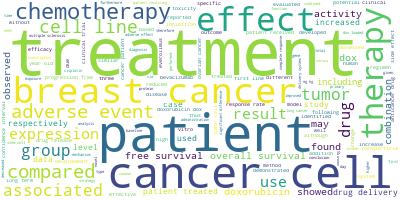

In [0]:
#Exploratory Analysis
# Import the wordcloud library

from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df['text'].values))


# Create a WordCloud object

wordcloud = WordCloud(background_color='white' , max_words=5000 , contour_width=3 , contour_color='steelblue')


# Generate a word cloud

wordcloud.generate(long_string)


# Visualize the word cloud

wordcloud.to_image()

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
import re

cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(df['text'])

list(cv.vocabulary_.keys())[:10]


['colorectal',
 'liver',
 'metastasis',
 'develops',
 'patient',
 'diagnosed',
 'cancer',
 'whereas',
 'concurrent',
 'cholangiocarcinoma']

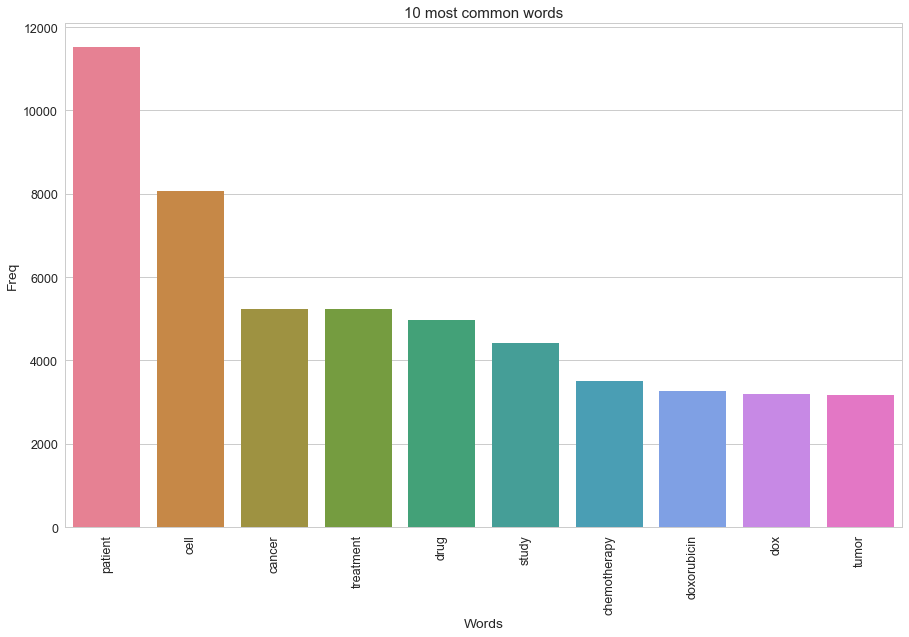

In [0]:
#Prepare text for LDA Analysis

# Load the library with the CountVectorizer method

from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function

def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]

    
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('Words')
    plt.ylabel('Freq')
    plt.show()
                    

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
                    
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['text'])
                    
# Visualise the 10 most common words
plot_10_most_common_words(count_data , count_vectorizer)    



In [0]:
import nltk, re, string, collections
from nltk.util import ngrams # function for making ngrams



In [0]:
# first get individual words
tokenized = text.split()

# and get a list of all the bi-grams
esBigrams = ngrams(tokenized, 2)

# get the frequency of each bigram in our corpus
esBigramFreq = collections.Counter(esBigrams)


esBigramFreq.most_common(10)

[(('response', 'rate'), 3),
 (('oral', 'hexamethylmelamine'), 2),
 (('platin', 'resistance'), 2),
 (('progression', 'stable'), 2),
 (('stable', 'disease'), 2),
 (('relapse', 'within'), 2),
 (('within', 'month'), 2),
 (('objective', 'response'), 2),
 (('month', 'patient'), 2),
 (('patient', 'progression'), 2)]

In [0]:

# first get individual words
tokenized = text.split()

# and get a list of all the tri-grams
esBigrams = ngrams(tokenized, 3)

# get the frequency of each bigram in our corpus
esBigramFreq = collections.Counter(esBigrams)


esBigramFreq.most_common(10)
   


[(('progression', 'stable', 'disease'), 2),
 (('relapse', 'within', 'month'), 2),
 (('objective', 'response', 'rate'), 2),
 (('month', 'patient', 'progression'), 2),
 (('total', 'patient', 'recurrent'), 1),
 (('patient', 'recurrent', 'persistent'), 1),
 (('recurrent', 'persistent', 'clinically'), 1),
 (('persistent', 'clinically', 'measurable'), 1),
 (('clinically', 'measurable', 'platin'), 1),
 (('measurable', 'platin', 'resistant'), 1)]

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names

feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc=df['text'][532]
 
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

tf_idf_vector

<1x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 71 stored elements in Compressed Sparse Row format>

In [0]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=30):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,6)
                                 
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
cashew gum cg grafted n isopropylacrylamide nipa radical polymerization originate stimulus sensitive copolymer drug delivery purpose nmr ir spectroscopy confirmed insertion nipa onto cashew gum chain graft copolymer cg nipa demonstrated thermal responsiveness critical aggregation concentration copolymer c higher c temperature lower lcst nanoparticle size ranged nm depending cg nipa ratio lcst particle aggregated increasing particle size regarding potential future oral application nanoparticles showed cytotoxic activity caco ht mtx intestine cell line epirubicin encapsulated nanoparticles cg nipa resulting association efficiency loading capacity thus cg nipa graft copolymer demonstrates good potential used controlled drug delivery system

Keywords:
cg 0.607
copolymer 0.321
graft 0.195
particle 0.162
size 0.129
